# Imports

In [1]:
# Import necessary libraries
import imageio
import numpy as np
import os
import matplotlib.pyplot as plt
from background_removal_exp.opt_bckg_rmv import *
from descriptors import preprocess_image
from image_split import split_images


# Path to the images
image_folder = "../Data/Week3/qsd2_w3/"  # Update this path as necessary
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
mask_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
image_files.sort()
mask_files.sort()

# Func Principal

C:\Users\Adrià\AppData\Local\Temp\ipykernel_22372\2375818142.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(image_path)  # RGB


[DEBUG] num_clusters_C = 4, labels = [1250 1344 1623 1681]
[DEBUG] num_clusters_CF = 3, labels = [1250 1344 1623]
[DEBUG] Warning: multiple clusters in CF.  Falling back to background cluster mask.
[DEBUG] Final mask computation complete.
[DEBUG] Final mask area = 185339, mask dtype = uint8


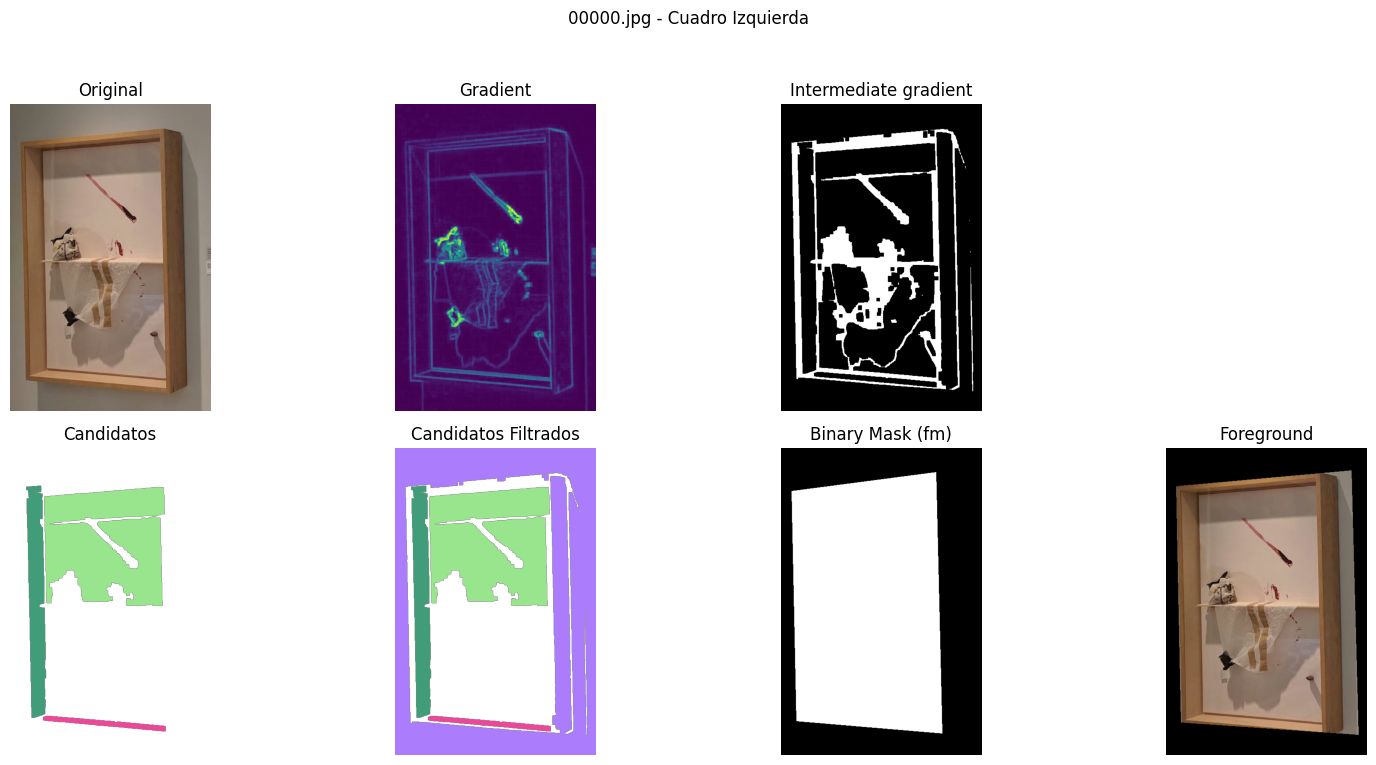

C:\Users\Adrià\AppData\Local\Temp\ipykernel_22372\2375818142.py:94: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gt_raw = imageio.imread(gt_path)


00000.jpg -> Precision: 0.9958, Recall: 0.8673, F1: 0.9272


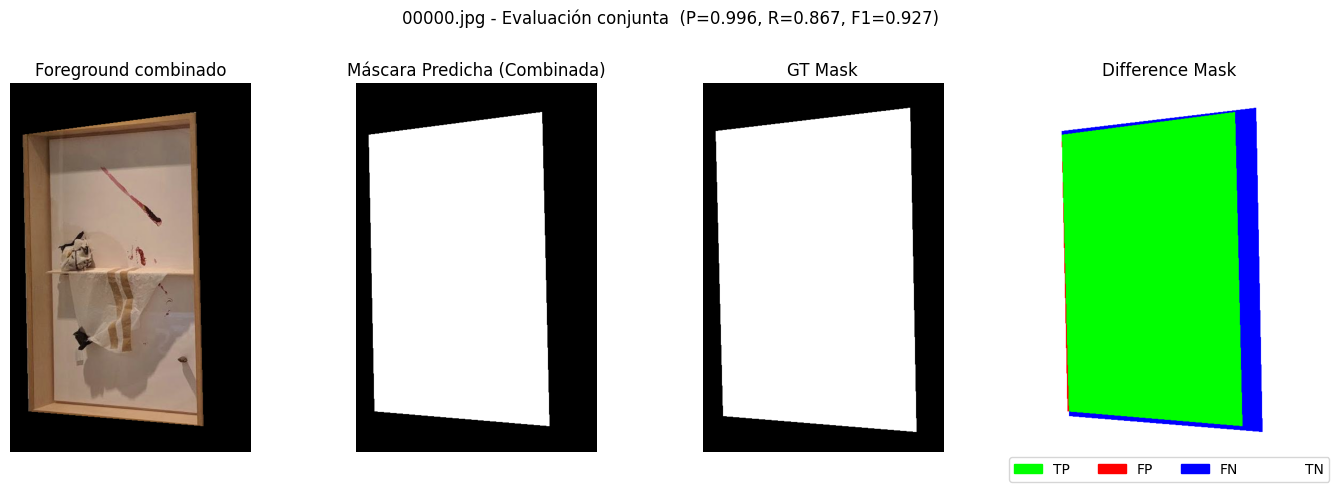

In [ ]:
# Iterar sobre imágenes, comparar con GT, calcular métricas y mostrar resultados
import matplotlib.patches as mpatches

# Toggle plotting of images. Set to False to speed-up and only print metrics.
SHOW_PLOTS = True
os.makedirs("outputs", exist_ok=True)

precisions = []
recalls = []
f1s = []

it = 0

for idx, image_file in enumerate(image_files):
    image_path = os.path.join(image_folder, image_file)
    im = imageio.imread(image_path)  # RGB

    # 1️⃣ Convertir a BGR para split_images (compatibilidad con cv2)
    im_bgr = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)

    # 2️⃣ Separar imagen (puede devolver una o dos imágenes)
    valleys, splitted = split_images(im_bgr)

    # split_images devuelve imágenes en BGR → convertimos de nuevo a RGB
    if isinstance(splitted, (list, tuple)):
        parts = [cv2.cvtColor(s, cv2.COLOR_BGR2RGB) for s in splitted]
    else:
        parts = [cv2.cvtColor(splitted, cv2.COLOR_BGR2RGB)]

    part_labels = ["izquierda", "derecha"][:len(parts)]
    results = []

    # 3️⃣ Procesar cada subimagen individualmente
    for i, part in enumerate(parts):
        preprocessed = preprocess_image(part)
        result = remove_background_morphological_gradient(preprocessed)
        results.append(result)

        if SHOW_PLOTS:
            original_image, pred_mask, foreground, grad_norm, gn, sc, sc2, fm = result

            plt.figure(figsize=(16, 8))
            plt.suptitle(f"{image_file} - Cuadro {part_labels[i].capitalize()}")

            plt.subplot(2, 4, 1)
            plt.title('Original')
            plt.imshow(original_image)
            plt.axis('off')

            plt.subplot(2, 4, 2)
            plt.title('Gradient')
            plt.imshow(grad_norm, cmap='viridis')
            plt.axis('off')

            plt.subplot(2, 4, 3)
            plt.title('Intermediate gradient')
            plt.imshow(gn, cmap='gray')
            plt.axis('off')

            plt.subplot(2, 4, 5)
            plt.title('Candidatos')
            plt.imshow(sc2)
            plt.axis('off')

            plt.subplot(2, 4, 6)
            plt.title('Candidatos Filtrados')
            plt.imshow(sc)
            plt.axis('off')

            plt.subplot(2, 4, 7)
            plt.title('Binary Mask (fm)')
            plt.imshow(fm, cmap='gray')
            plt.axis('off')

            plt.subplot(2, 4, 8)
            plt.title('Foreground')
            plt.imshow(foreground)
            plt.axis('off')

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            save_path = os.path.join("outputs", f"{os.path.splitext(image_file)[0]}_{part_labels[i]}.png")
            plt.savefig(save_path)
            plt.show()

    # 4️⃣ Combinar máscaras si hubo división
    if len(results) == 1:
        pred_bool = results[0][7].astype(bool)  # fm
    else:
        pred_bool = np.hstack([r[7].astype(bool) for r in results])

    # 5️⃣ Leer GT completa (sin dividir)
    base = os.path.splitext(image_file)[0]
    gt_path = os.path.join(image_folder, base + '.png')
    gt_raw = imageio.imread(gt_path)
    gt_bool = gt_raw > 127

    # 6️⃣ Alinear tamaños
    h = min(pred_bool.shape[0], gt_bool.shape[0])
    w = min(pred_bool.shape[1], gt_bool.shape[1])
    pred_bool = pred_bool[:h, :w]
    gt_bool = gt_bool[:h, :w]

    # ⚙️ Reconstruir foreground combinado aplicando la máscara sobre la imagen original
    # (Debe hacerse sobre la imagen original sin procesar)
    im_resized = im[:h, :w, :]  # imagen original recortada al tamaño válido
    combined_foreground = im_resized * pred_bool[..., np.newaxis]

    # 7️⃣ Calcular métricas conjuntas
    TP = np.logical_and(pred_bool, gt_bool).sum()
    FP = np.logical_and(pred_bool, np.logical_not(gt_bool)).sum()
    FN = np.logical_and(np.logical_not(pred_bool), gt_bool).sum()
    TN = np.logical_and(np.logical_not(pred_bool), np.logical_not(gt_bool)).sum()

    P = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    R = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    F1 = 2 * P * R / (P + R) if (P + R) > 0 else 0.0

    precisions.append(P)
    recalls.append(R)
    f1s.append(F1)

    print(f"{image_file} -> Precision: {P:.4f}, Recall: {R:.4f}, F1: {F1:.4f}")

    # 8️⃣ Mostrar máscara combinada + GT + diferencias + foreground combinado
    if SHOW_PLOTS:
        h, w = pred_bool.shape
        diff_rgb = np.zeros((h, w, 3), dtype=np.uint8)
        diff_rgb[np.logical_and(pred_bool, gt_bool)] = [0, 255, 0]     # TP
        diff_rgb[np.logical_and(pred_bool, np.logical_not(gt_bool))] = [255, 0, 0]  # FP
        diff_rgb[np.logical_and(np.logical_not(pred_bool), gt_bool)] = [0, 0, 255]  # FN
        diff_rgb[np.logical_and(np.logical_not(pred_bool), np.logical_not(gt_bool))] = [255, 255, 255]  # TN

        plt.figure(figsize=(14, 5))
        plt.suptitle(f"{image_file} - Evaluación conjunta  (P={P:.3f}, R={R:.3f}, F1={F1:.3f})")

        plt.subplot(1, 4, 1)
        plt.title('Foreground combinado')
        plt.imshow(combined_foreground)
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.title('Máscara Predicha (Combinada)')
        plt.imshow(pred_bool, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.title('GT Mask')
        plt.imshow(gt_bool, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.title('Difference Mask')
        plt.imshow(diff_rgb)
        plt.axis('off')

        patches = [
            mpatches.Patch(color=(0, 1, 0), label='TP'),
            mpatches.Patch(color=(1, 0, 0), label='FP'),
            mpatches.Patch(color=(0, 0, 1), label='FN'),
            mpatches.Patch(color=(1, 1, 1), label='TN')
        ]
        plt.legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=4)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        save_path = os.path.join("outputs", f"{base}_eval.png")
        plt.savefig(save_path)
        plt.show()



global_precision = np.mean(precisions)
global_recall = np.mean(recalls)
global_f1 = np.mean(f1s)

print('\n=== Global pixel-wise metrics ===')
print(f'Precision: {global_precision:.4f} | Recall: {global_recall:.4f} | F1: {global_f1:.4f}')